## Import the necessary libraries

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Check and enable GPU
!nvidia-smi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

fish: Unknown command: nvidia-smi
fish: 
nvidia-smi
^~~~~~~~~^
Using device: cpu


## Data Preparation and Loading

We prepare the MNIST dataset using torchvision, applying a simple transformation to convert images to tensors. The training data is loaded using a DataLoader for efficient batching and shuffling. This setup is essential for training the Conditional Variational Autoencoder (CVAE) model on handwritten digit images.

In [36]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_val)

## Model Architecture

We define a Conditional Variational Autoencoder (CVAE) model using PyTorch. The encoder takes both the input image and its corresponding label (as an additional channel), processes them through convolutional layers, and outputs the mean and log-variance for the latent space. The decoder reconstructs the image from the latent vector concatenated with the label information. This architecture enables the model to generate images conditioned on specific digit labels, allowing for controlled generation of handwritten digits.

In [37]:
def improved_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Use MSE loss for better reconstruction
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence with beta weighting
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + beta * KLD

In [38]:
class ImprovedCVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(ImprovedCVAE, self).__init__()
        self.latent_dim = latent_dim
        self.label_dim = 10

        # Improved Encoder with BatchNorm and Dropout
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + 1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),     # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),    # 7x7 -> 4x4 (with padding adjustment)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Flatten()
        )
        
        # Correct flattened size calculation: 
        # Input: 28x28 -> Conv1: 14x14 -> Conv2: 7x7 -> Conv3: 3x3 (28->14->7->3)
        # But with padding=1: 28->14->7->4, so it's actually 128 * 3 * 3 = 1152
        self.flattened_size = 128 * 3 * 3  # Fixed calculation

        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)

        # Improved Decoder
        self.decoder_input = nn.Linear(latent_dim + self.label_dim, 128 * 3 * 3)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 3, 3)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 3x3 -> 6x6
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 6x6 -> 12x12
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=1),    # 12x12 -> 25x25
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=4, stride=1, padding=0),     # 25x25 -> 28x28
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels_onehot):
        # Better label conditioning - create label map with same spatial dimensions as input
        label_map = labels_onehot.view(-1, 10, 1, 1).expand(-1, -1, 28, 28)
        # Use first channel of label map (or sum across label dimensions)
        label_channel = torch.sum(label_map * torch.arange(10, device=x.device).view(1, 10, 1, 1), dim=1, keepdim=True) / 45.0  # normalize by max sum
        x_cond = torch.cat([x, label_channel], dim=1)

        encoded = self.encoder(x_cond)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)

        z_cond = torch.cat([z, labels_onehot], dim=1)
        dec_input = self.decoder_input(z_cond)
        x_recon = self.decoder(dec_input)
        return x_recon, mu, logvar

## Model Training

We train the Conditional Variational Autoencoder (CVAE) using the MNIST training dataset. For each epoch, the model processes batches of images and their corresponding labels, computes the reconstruction and KL divergence losses, and updates the model parameters using the Adam optimizer. The training loop prints the average loss per epoch, providing insight into the model's learning progress.

In [39]:
# Add validation dataset
val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

model = ImprovedCVAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

epochs = 50
beta = 1.0
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        labels_onehot = nn.functional.one_hot(labels, num_classes=10).float()

        optimizer.zero_grad()
        recon, mu, logvar = model(images, labels_onehot)
        loss = improved_loss_function(recon, images, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_onehot = nn.functional.one_hot(labels, num_classes=10).float()
            
            recon, mu, logvar = model(images, labels_onehot)
            loss = improved_loss_function(recon, images, mu, logvar, beta)
            val_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "cvae_mnist.pth")
    
    scheduler.step()
    
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    print("-" * 50)

Epoch 1/50
Train Loss: 171.1948, Val Loss: 141.3906
LR: 0.001000
--------------------------------------------------
Epoch 2/50
Train Loss: 100.5693, Val Loss: 47.9909
LR: 0.001000
--------------------------------------------------
Epoch 3/50
Train Loss: 46.4329, Val Loss: 45.4971
LR: 0.001000
--------------------------------------------------
Epoch 4/50
Train Loss: 44.2546, Val Loss: 43.6108
LR: 0.001000
--------------------------------------------------
Epoch 5/50
Train Loss: 42.2005, Val Loss: 41.4392
LR: 0.001000
--------------------------------------------------
Epoch 6/50
Train Loss: 40.1443, Val Loss: 39.3317
LR: 0.001000
--------------------------------------------------
Epoch 7/50
Train Loss: 38.1524, Val Loss: 37.2086
LR: 0.001000
--------------------------------------------------
Epoch 8/50
Train Loss: 36.2111, Val Loss: 35.1986
LR: 0.001000
--------------------------------------------------
Epoch 9/50
Train Loss: 34.3728, Val Loss: 33.3684
LR: 0.001000
----------------------

In [40]:
torch.save(model.state_dict(), "cvae_mnist.pth")

## Image Generation

In [41]:
digit = 5 

In [42]:
model.eval()

num_samples = 5
label = torch.full((num_samples,), digit, dtype=torch.long)
label_onehot = nn.functional.one_hot(label, num_classes=10).float().to(device)

# Sample random noise from normal distribution
z = torch.randn(num_samples, model.latent_dim).to(device)

# Concatenate latent vector with one-hot label
z_cond = torch.cat([z, label_onehot], dim=1)


In [43]:
with torch.no_grad():
    decoder_input = model.decoder_input(z_cond)
    generated = model.decoder(decoder_input) 


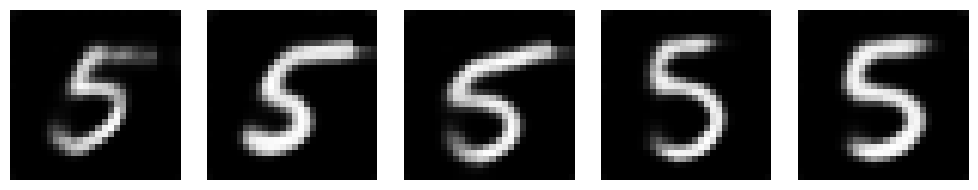

In [44]:
generated = generated.cpu()

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axs[i].imshow(generated[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()
